In [20]:
import tensorflow as tf
from tf_agents.agents import ddpg
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
import wandb

import sys
sys.path.insert(0, '..')
import utils.dataloader as dataloader
import environments.battery as battery_env
import environments.household as household_env

"""
Train and evaluate a DDPG agent
"""

# Param for iteration
num_iterations = 5000
customer = 1
# 0 = battery, 1 = household
env = 0
# Params for collect
initial_collect_steps = 1000
collect_steps_per_iteration = 2000
replay_buffer_capacity = 1000000
ou_stddev = 0.2
ou_damping = 0.15

# Params for target update
target_update_tau = 0.05
target_update_period = 5

# Params for train
train_steps_per_iteration = 1
batch_size = 48 * 7
actor_learning_rate = 1e-4
critic_learning_rate = 1e-3
dqda_clipping = None
td_errors_loss_fn = tf.compat.v1.losses.huber_loss
gamma = 0.99
reward_scale_factor = 1.0
gradient_clipping = None

# Params for eval and checkpoints
num_eval_episodes = 1
num_test_episodes = 1
eval_interval = 50

# Load data
data_train = dataloader.get_customer_data(dataloader.loadData('./data/load1011.csv'),
                                          dataloader.loadPrice('./data/price_wo_outlier.csv'), dataloader.loadMix("./data/fuel2021.csv"), customer)
data_eval = dataloader.get_customer_data(dataloader.loadData('./data/load1112.csv'),
                                         dataloader.loadPrice('./data/price_wo_outlier.csv'), dataloader.loadMix("./data/fuel2122.csv"), customer)
data_test = dataloader.get_customer_data(dataloader.loadData('./data/load1213.csv'),
                                         dataloader.loadPrice('./data/price_wo_outlier.csv'), dataloader.loadMix("./data/fuel2223.csv"), customer)

# Initiate env
if env == 0:
    tf_env_train = tf_py_environment.TFPyEnvironment(battery_env.Battery(init_charge=0.0, data=data_train))
    tf_env_eval = tf_py_environment.TFPyEnvironment(battery_env.Battery(init_charge=0.0, data=data_eval))
else:
    tf_env_train = tf_py_environment.TFPyEnvironment(household_env.Household(init_charge=0.0, data=data_train))
    tf_env_eval = tf_py_environment.TFPyEnvironment(household_env.Household(init_charge=0.0, data=data_eval))

# Prepare runner
global_step = tf.compat.v1.train.get_or_create_global_step()

actor_net = ddpg.actor_network.ActorNetwork(
    input_tensor_spec=tf_env_train.observation_spec(),
    output_tensor_spec=tf_env_train.action_spec(), fc_layer_params=(400, 300),
    activation_fn=tf.keras.activations.relu)

critic_net = ddpg.critic_network.CriticNetwork(
    input_tensor_spec=(tf_env_train.observation_spec(), tf_env_train.action_spec()),
    joint_fc_layer_params=(400, 300),
    activation_fn=tf.keras.activations.relu)

tf_agent = ddpg_agent.DdpgAgent(
    tf_env_train.time_step_spec(),
    tf_env_train.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate
    ),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate
    ),
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    dqda_clipping=dqda_clipping,
    td_errors_loss_fn=td_errors_loss_fn,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=False,
    summarize_grads_and_vars=False,
    train_step_counter=global_step,
)

tf_agent.initialize()

eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    tf_agent.collect_data_spec,
    batch_size=tf_env_train.batch_size,
    max_length=replay_buffer_capacity,
)

initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env_train,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps,
)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env_train,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration,
)

wandb.login()
wandb.init(
    project="DDPG_battery",
    job_type="train_eval_test",
    name="3_ex_09",
    config={
        "train_steps": num_iterations,
        "batch_size": batch_size,
        "actor_learning_rate": actor_learning_rate,
        "critic_learning_rate": critic_learning_rate}
)

artifact = wandb.Artifact(name='save', type="checkpoint")

eval_metrics = [
    tf_metrics.AverageReturnMetric(name="AverageReturnEvaluation", buffer_size=num_eval_episodes)
]

test_metrics = [
    tf_metrics.AverageReturnMetric(name="AverageReturnTest", buffer_size=num_eval_episodes)
]

train_checkpointer = common.Checkpointer(
    ckpt_dir='checkpoints/ddpg/',
    max_to_keep=1,
    agent=tf_agent,
    policy=tf_agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

train_checkpointer.initialize_or_restore()

global_step = tf.compat.v1.train.get_global_step()

# For better performance
initial_collect_driver.run = common.function(initial_collect_driver.run)
collect_driver.run = common.function(collect_driver.run)
tf_agent.train = common.function(tf_agent.train)

# Collect initial replay data
initial_collect_driver.run()

time_step = tf_env_train.reset()
policy_state = collect_policy.get_initial_state(tf_env_train.batch_size)

# Dataset generates trajectories with shape [Bx2x...]
# pipeline which will feed data to the agent
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2
).prefetch(3)
iterator = iter(dataset)

# Train and evaluate
print("Start training ...")
while global_step.numpy() < num_iterations:
    time_step, policy_state = collect_driver.run(
        time_step=time_step,
        policy_state=policy_state,
    )
    experience, _ = next(iterator)
    train_loss = tf_agent.train(experience)
    metrics = {}
    if global_step.numpy() % eval_interval == 0:
        train_checkpointer.save(global_step)
        metrics = metric_utils.eager_compute(
            eval_metrics,
            tf_env_eval,
            eval_policy,
            num_episodes=num_eval_episodes,
            train_step=global_step,
            summary_writer=None,
            summary_prefix='',
            use_function=True)
    
    metrics["loss"] = train_loss.loss
    wandb.log(metrics)

# Initiate test env
if env == 0:
    tf_env_test = tf_py_environment.TFPyEnvironment(battery_env.Battery(init_charge=0.0, data=data_test, test=True))
else:
    tf_env_test = tf_py_environment.TFPyEnvironment(household_env.Household(init_charge=0.0, data=data_test, test=True))

print("Start testing ...")
metrics = metric_utils.eager_compute(
    test_metrics,
    tf_env_test,
    eval_policy,
    num_episodes=num_test_episodes,
    train_step=None,
    summary_writer=None,
    summary_prefix='',
    use_function=True)
wandb.log(metrics)
artifact.add_dir(local_path='checkpoints/ddpg/')
wandb.log_artifact(artifact)
wandb.finish()

FileNotFoundError: [Errno 2] No such file or directory: './data/load1011.csv'

In [10]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tf_agents.agents import ddpg
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.networks import network
import wandb

import sys
sys.path.insert(0, '..')
import utils.dataloader as DL
import environments.battery as battery_env
import environments.household as household_env

import os
os.environ["WANDB_NOTEBOOK_NAME"] = "DDPG_keras.ipynb"

In [11]:
# Get Data

customer = 1
# Create data arrays for customer (0->load, 1->pv, 2->price)
data_train = DL.get_customer_data(DL.loadData('../../data/load1011.csv'), DL.loadPrice('../../data/price_wo_outlier.csv'), DL.loadMix("../../data/fuel2021.csv"), customer)
data_eval = DL.get_customer_data(DL.loadData('../../data/load1112.csv'), DL.loadPrice('../../data/price_wo_outlier.csv'), DL.loadMix("../../data/fuel2122.csv"), customer)
data_test = DL.get_customer_data(DL.loadData('../../data/load1213.csv'), DL.loadPrice('../../data/price_wo_outlier.csv'), DL.loadMix("../../data/fuel2223.csv"), customer)

<Axes: >

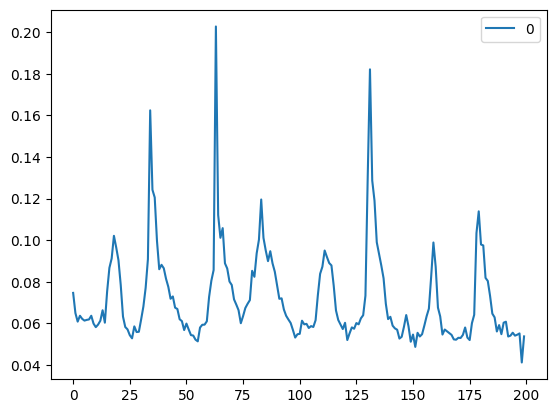

In [12]:
data_train[2][:200].plot()

In [13]:
# Initialize environment
tf_env_train = tf_py_environment.TFPyEnvironment(battery_env.Battery(init_charge=0.0, data=data_train))
tf_env_eval = tf_py_environment.TFPyEnvironment(battery_env.Battery(init_charge=0.0, data=data_eval))

#tf_env_train = Battery(load_data=data_train[0], pv_data=data_train[1], price_data=data_train[2])
#tf_env_eval = Battery(load_data=data_train[0], pv_data=data_train[1], price_data=data_train[2])

num_states = tf_env_train.observation_spec().shape[0]
print("Size of State Space ->  {}".format(num_states)) #SoE, price, price forecast 1-6
num_actions = tf_env_train.action_spec().shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = tf_env_train.action_spec().maximum.item()
lower_bound = tf_env_train.action_spec().minimum.item()

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  8
Size of Action Space ->  1
Max Value of Action ->  2.299999952316284
Min Value of Action ->  -2.299999952316284


In [15]:
# Set Hyperparameters

# Param for iteration
num_iterations = 5000
customer = 1
# 0 = battery, 1 = household
env = 0
# Params for collect
initial_collect_steps = 1000
collect_steps_per_iteration = 2000

ou_stddev = 0.2
ou_damping = 0.15

# Params for target update
target_update_tau = 0.05
target_update_period = 5

# Params for train
train_steps_per_iteration = 1
replay_buffer_capacity = 1000000
batch_size = 48 * 7
actor_learning_rate = 1e-4
critic_learning_rate = 1e-3
dqda_clipping = None
td_errors_loss_fn = tf.compat.v1.losses.huber_loss
gamma = 0.99
reward_scale_factor = 1.0
gradient_clipping = None

# Params for eval and checkpoints
num_eval_episodes = 1
num_test_episodes = 1
eval_interval = 50

In [16]:
class ActorNetwork(network.Network):

    def __init__(self, input_tensor_spec, output_tensor_spec, activation_fn=tf.keras.activations.relu, name='ActorNetwork'):
        super(ActorNetwork, self).__init__(input_tensor_spec=input_tensor_spec,state_spec=(),name=name)

        # Initialize _layers as an empty list
        self._layers = []

        # Define layers here
        self._layers.append(tf.keras.layers.Dense(400, activation=activation_fn))
        self._layers.append(tf.keras.layers.Dense(300, activation=activation_fn))
        
        # Ensure the output layer matches the action spec
        num_actions = output_tensor_spec.shape[0]
        self._layers.append(tf.keras.layers.Dense(num_actions, activation='tanh'))
        self._output_scale = upper_bound 
    
    def call(self, observations, step_type=None, network_state=()):
        x = tf.cast(observations, dtype=tf.float32)
        for layer in self._layers:
            x = layer(x)
        
        # Scale the output to be between -2.3 and 2.3
        actions = x #* self._output_scale
       
        return actions, network_state
    

In [17]:
# Prepare runner
global_step = tf.compat.v1.train.get_or_create_global_step()

actor_net = ActorNetwork(
    input_tensor_spec=tf_env_train.observation_spec(),
    output_tensor_spec=tf_env_train.action_spec(),
    activation_fn=tf.keras.activations.relu)

critic_net = ddpg.critic_network.CriticNetwork(
    input_tensor_spec=(tf_env_train.observation_spec(), tf_env_train.action_spec()),
    joint_fc_layer_params=(400, 300),
    activation_fn=tf.keras.activations.relu)

tf_agent = ddpg_agent.DdpgAgent(
    tf_env_train.time_step_spec(),
    tf_env_train.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate
    ),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate
    ),
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    dqda_clipping=dqda_clipping,
    td_errors_loss_fn=td_errors_loss_fn,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=False,
    summarize_grads_and_vars=False,
    train_step_counter=global_step,
)

tf_agent.initialize()

eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    tf_agent.collect_data_spec,
    batch_size=batch_size,
    max_length=replay_buffer_capacity,
)

initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env_train,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps,
)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env_train,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration,
)

In [18]:
wandb.login()
wandb.init(
    project="DDPG_battery_testing",
    job_type="train_eval_test",
    name="3_ex_09",
    config={
        "train_steps": num_iterations,
        "batch_size": batch_size,
        "actor_learning_rate": actor_learning_rate,
        "critic_learning_rate": critic_learning_rate}
)

artifact = wandb.Artifact(name='save', type="checkpoint")

eval_metrics = [
    tf_metrics.AverageReturnMetric(name="AverageReturnEvaluation", buffer_size=num_eval_episodes)
]

test_metrics = [
    tf_metrics.AverageReturnMetric(name="AverageReturnTest", buffer_size=num_eval_episodes)
]

"""train_checkpointer = common.Checkpointer(
    ckpt_dir='checkpoints/ddpg/',
    max_to_keep=1,
    agent=tf_agent,
    policy=tf_agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

train_checkpointer.initialize_or_restore()"""

global_step = tf.compat.v1.train.get_global_step()

# For better performance
initial_collect_driver.run = common.function(initial_collect_driver.run)
collect_driver.run = common.function(collect_driver.run)
tf_agent.train = common.function(tf_agent.train)

# Collect initial replay data
initial_collect_driver.run()

time_step = tf_env_train.reset()
policy_state = collect_policy.get_initial_state(tf_env_train.batch_size)

# Dataset generates trajectories with shape [Bx2x...]
# pipeline which will feed data to the agent
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2
).prefetch(3)
iterator = iter(dataset)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


ValueError: Dimension 0 in both shapes must be equal, but are 1 and 336. Shapes are [1] and [336]. for '{{node driver_loop/TFUniformReplayBuffer/ResourceScatterUpdate_1}} = ResourceScatterUpdate[Tindices=DT_INT64, dtype=DT_INT32](driver_loop/TFUniformReplayBuffer/ResourceScatterUpdate_1/resource, driver_loop/TFUniformReplayBuffer/add, driver_loop/Placeholder_1)' with input shapes: [], [336], [1].

In [ ]:
num_iterations = 2000
# Train and evaluate
print("Start training ...")
while global_step.numpy() < num_iterations:
    # Collect data from the environment using the collect driver.
    
    print(global_step.numpy(), " / ", num_iterations)
    
    time_step, policy_state = collect_driver.run(
        time_step=time_step,
        policy_state=policy_state,
    )
    # Get the next batch of experiences from the iterator.
    experience, _ = next(iterator)
    # Train the agent with the collected experience and record the loss.
    train_loss = tf_agent.train(experience)
    metrics = {}
    if global_step.numpy() % eval_interval == 0:
        #train_checkpointer.save(global_step)
        metrics = metric_utils.eager_compute(
            eval_metrics,
            tf_env_eval,
            eval_policy,
            num_episodes=num_eval_episodes,
            train_step=global_step,
            summary_writer=None,
            summary_prefix='',
            use_function=True)
        print("Evaluation - ", train_loss.loss)
    
    metrics["loss"] = train_loss.loss
    wandb.log(metrics)

# Initiate test env
if env == 0:
    tf_env_test = tf_py_environment.TFPyEnvironment(battery_env.Battery(init_charge=0.0, data=data_test, test=True))
else:
    tf_env_test = tf_py_environment.TFPyEnvironment(household_env.Household(init_charge=0.0, data=data_test, test=True))

print("Start testing ...")
metrics = metric_utils.eager_compute(
    test_metrics,
    tf_env_test,
    eval_policy,
    num_episodes=num_test_episodes,
    train_step=None,
    summary_writer=None,
    summary_prefix='',
    use_function=True)
wandb.log(metrics)
artifact.add_dir(local_path='checkpoints/ddpg/')
wandb.log_artifact(artifact)
wandb.finish()

Start training ...
0  /  2000
1  /  2000
2  /  2000
3  /  2000
4  /  2000
5  /  2000
6  /  2000
7  /  2000
8  /  2000
9  /  2000
10  /  2000
11  /  2000
12  /  2000
13  /  2000
14  /  2000
15  /  2000
16  /  2000
17  /  2000
18  /  2000
19  /  2000
20  /  2000
21  /  2000
22  /  2000
23  /  2000
24  /  2000
25  /  2000
26  /  2000
27  /  2000
28  /  2000
29  /  2000
30  /  2000
31  /  2000
32  /  2000
33  /  2000
34  /  2000
35  /  2000
36  /  2000
37  /  2000
38  /  2000
39  /  2000
40  /  2000
41  /  2000
42  /  2000
43  /  2000
44  /  2000
45  /  2000
46  /  2000
47  /  2000
48  /  2000
49  /  2000
Evaluation -  tf.Tensor(0.0019582373, shape=(), dtype=float32)
50  /  2000
51  /  2000
52  /  2000
53  /  2000
54  /  2000
55  /  2000
56  /  2000
57  /  2000
58  /  2000
59  /  2000
60  /  2000
61  /  2000
62  /  2000
63  /  2000
64  /  2000
65  /  2000
66  /  2000
67  /  2000
68  /  2000
69  /  2000
70  /  2000
71  /  2000
72  /  2000
73  /  2000
74  /  2000
75  /  2000
76  /  2000
77  

ValueError: Path is not a directory: checkpoints/ddpg/